In [1]:
import geopandas as gpd
import h5py
import importlib
import json
import lxml
import math
import matplotlib
import numpy as np
import os
import pandas as pd
import pyproj as proj
import rasterio
import requests
import seaborn as sns
import sys
import time
import zipfile

from bs4 import BeautifulSoup
from datetime import datetime
from pathlib import Path
from scipy.stats import pearsonr
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from tqdm import tqdm

import Coral_Reef as coral_reef
#import ATL03_API as is2_api
import Depth_profile as depth
import ICESat2_plots as is2_plot
import ICESat2_file as is2_file
import Sentinel_API as sentinel
import Sentinel2_image as s2_img
import Sentinel_plots as s2_plot
import Reef_plots as reef_plots
import Pixel_transformation as pt
import Tide_API as tide
import Water_level as water_level

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import patches
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.ticker as ticker

import math
import numpy as np
import os
import pandas as pd

In [3]:
import cmocean
import scipy.stats

In [4]:
# Grab reef depths from before and after hurricane dorian

# right now using:
# 20190118 only pre-storm image we have so far (for some reason other s2 data not available)
# 20191124 post storm (best post-storm image in terms of clouds)
fd = '/Users/bonnieludka/Spaceship/IceSAT2/analysis_distribute/projects/abaco_bight/data/s2_depth_estimates/' 
f1 = 'abaco_bight_out_20190118155553.csv' 
fp1 = os.path.join(fd,f1)
rd1 = pd.read_csv(fp1)

f2 = 'abaco_bight_out_20191124155550.csv'
fp2 = os.path.join(fd,f2)
rd2 = pd.read_csv(fp2)

# Calculate Depth Change
rdiff = rd2.Height-rd1.Height

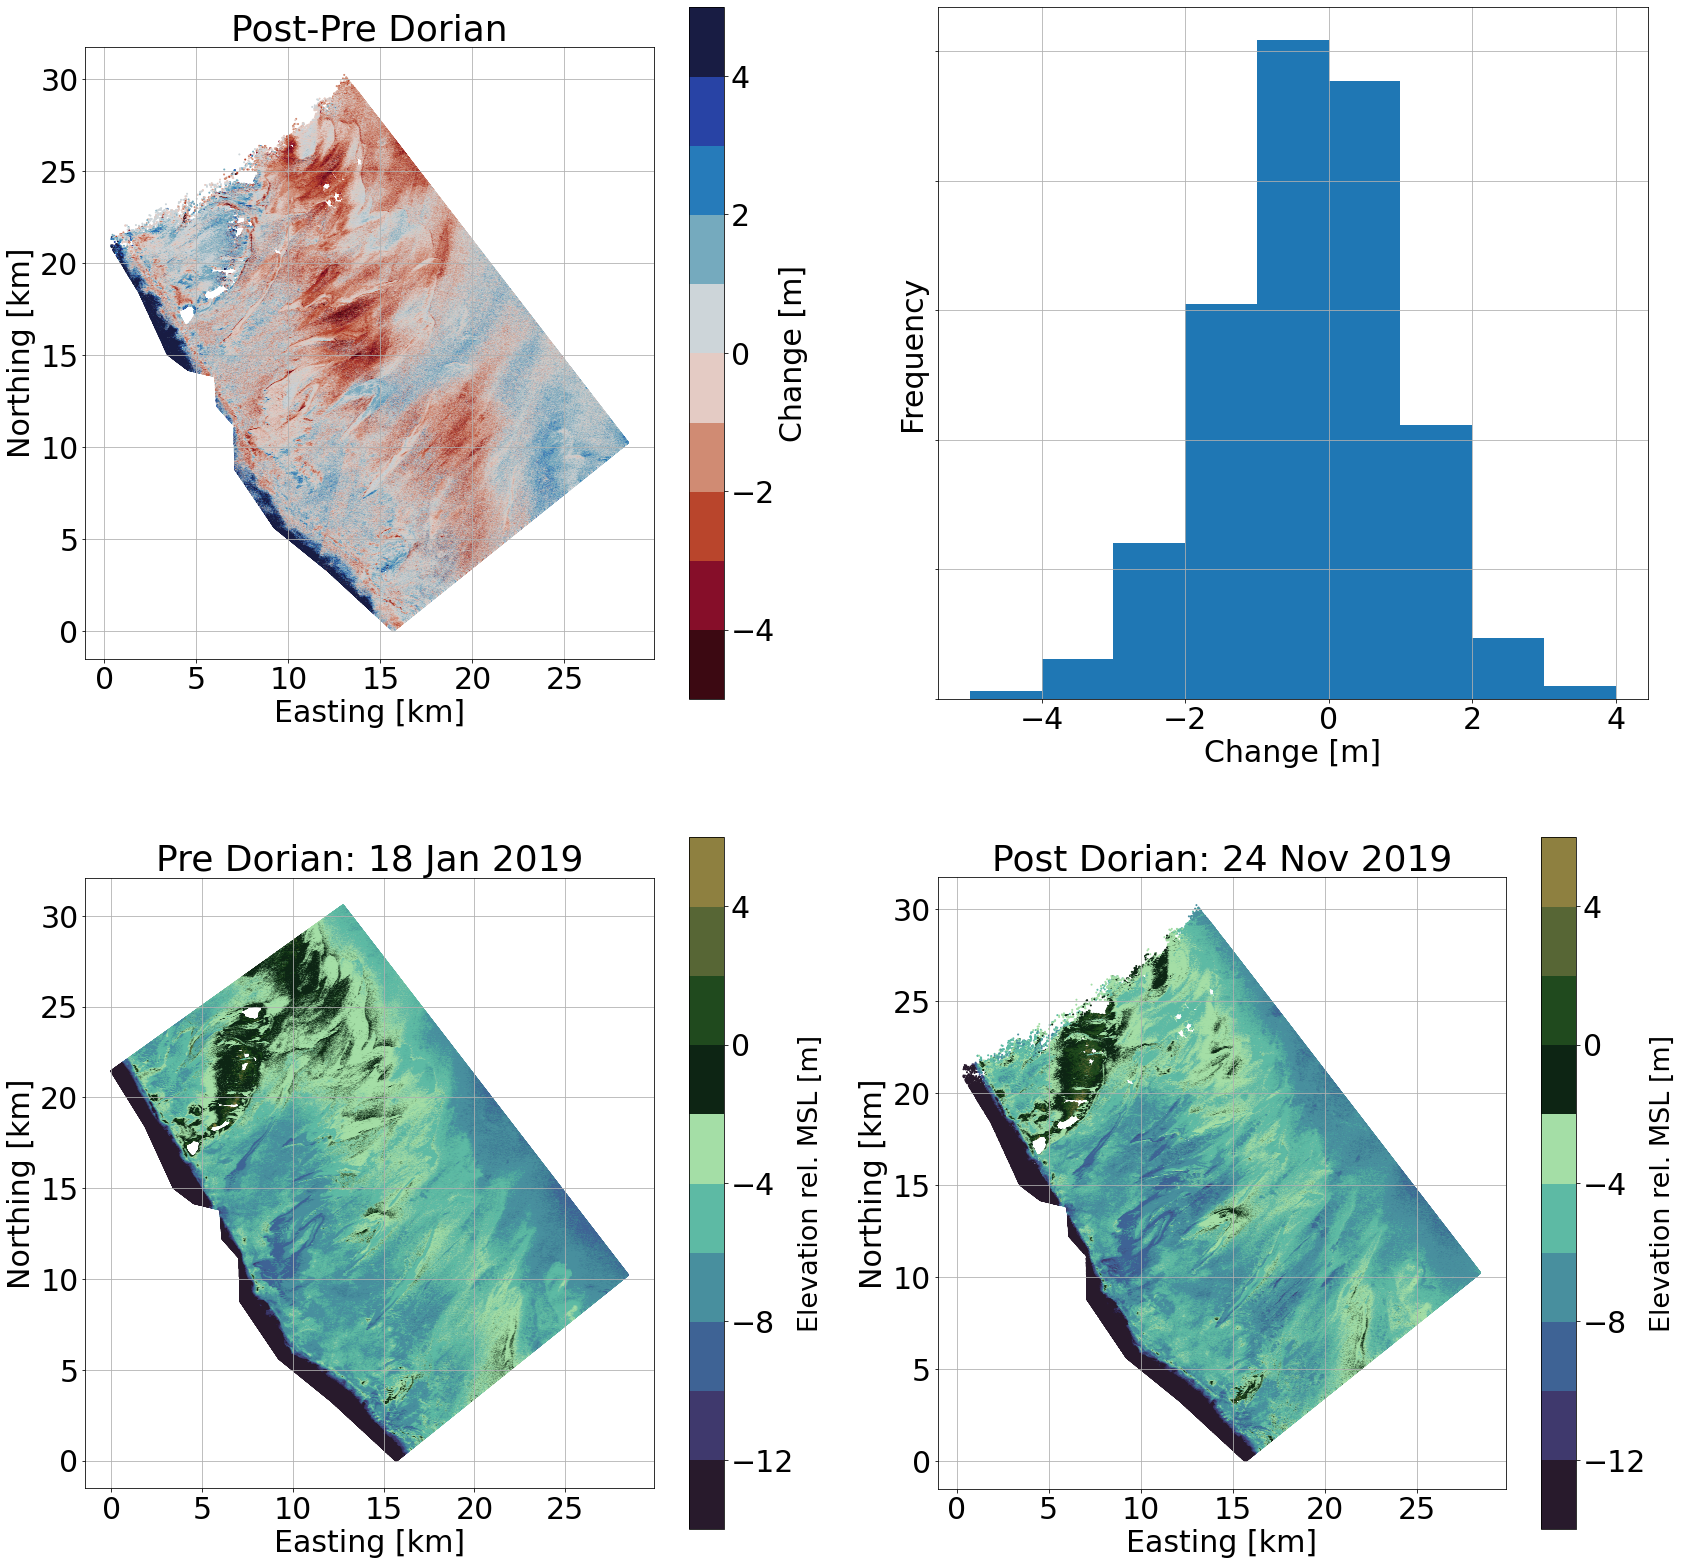

In [5]:
plt.rc('font', family='sans-serif', size=30)

fig, ax = plt.subplots(2, 2, figsize = (28,28))

utm_x0 = np.min(rd1.x)
utm_y0 = np.min(rd1.y)

# Scatter plot of depth change
cmap = cmocean.cm.balance_r
bounds = np.arange(-5,6,1)
norm = BoundaryNorm(bounds,ncolors = 256)
chg = ax[0,0].scatter(x = (rd1.x - utm_x0)/1000, y = (rd1.y - utm_y0)/1000, c = rdiff, s = 1, cmap = cmap, norm = norm)
ax[0,0].set_yticks(np.arange(0,31,5))
ax[0,0].set_xticks(np.arange(0,26,5))
ax[0,0].set_aspect('equal', 'box')
ax[0,0].set_ylabel('Northing [km]')
ax[0,0].set_xlabel('Easting [km]')
ax[0,0].set_title('Post-Pre Dorian')
cbar = fig.colorbar(chg, ax=ax[0,0])
cbar.set_label('Change [m]')
ax[0,0].grid(True)

# Histogram of depth changes
fig.patch.set_facecolor('white')
bns = np.arange(-5,5,1)
#hist = np.histogram(rdiff, bns)
#hist_dist = scipy.stats.rv_histogram(hist)
#dPDF = hist_dist.pdf(bns)
ax[0,1].hist(rdiff,bins = bns)
#ax[0,1].hist(dPDF,bins = bns)
ax[0,1].set_xlabel('Change [m]')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_yticklabels([])
ax[0,1].grid(True)

vmin = -14
vmax = 7
# Scatter plot of depth before hurricane
cmap = cmocean.tools.crop(cmocean.cm.topo, vmin, vmax, 0)
bounds = np.arange(vmin,vmax,2)
norm = BoundaryNorm(bounds,ncolors = 256)
dp1 = ax[1,0].scatter(x = (rd1.x - utm_x0)/1000, y = (rd1.y - utm_y0)/1000, c = rd1.Height, s = 1, cmap = cmap, norm = norm)
ax[1,0].set_yticks(np.arange(0,31,5))
ax[1,0].set_xticks(np.arange(0,26,5))
ax[1,0].set_aspect('equal', 'box')
ax[1,0].set_ylabel('Northing [km]')
ax[1,0].set_xlabel('Easting [km]')
ax[1,0].set_title('Pre Dorian: 18 Jan 2019')
cbar = fig.colorbar(dp1, ax=ax[1,0])
cbar.set_label('Elevation rel. MSL [m]',fontsize=27)
ax[1,0].grid(True)

# Scatter plot of depth after hurricane
cmap = cmocean.tools.crop(cmocean.cm.topo, vmin, vmax, 0)
bounds = np.arange(vmin,vmax,2)
norm = BoundaryNorm(bounds,ncolors = 256)
dp1 = ax[1,1].scatter(x = (rd1.x - utm_x0)/1000, y = (rd1.y - utm_y0)/1000, c = rd2.Height, s = 1, cmap = cmap, norm = norm)
ax[1,1].set_yticks(np.arange(0,31,5))
ax[1,1].set_xticks(np.arange(0,26,5))
ax[1,1].set_aspect('equal', 'box')
ax[1,1].set_ylabel('Northing [km]')
ax[1,1].set_xlabel('Easting [km]')
ax[1,1].set_title('Post Dorian: 24 Nov 2019')
cbar = fig.colorbar(dp1, ax=ax[1,1])
cbar.set_label('Elevation rel. MSL [m]',fontsize=27)
ax[1,1].grid(True)

# Save plot
sfd = '/Users/bonnieludka/Spaceship/IceSAT2/analysis_distribute/projects/abaco_bight/output/reef_depth_plots/' #save folder
pn = 'DorianDrivenAbacoBightDepthChange.png' #plot name
sp = os.path.join(sfd,pn) #save path
plt.savefig(sp)


In [6]:
print(rd1)

         Unnamed: 0              x             y     Height  \
0                 0  231026.662427  2.939311e+06  -5.485746   
1                 1  231036.662427  2.939311e+06  -4.916339   
2                 2  231046.662427  2.939311e+06  -5.440740   
3                 3  231016.662427  2.939301e+06  -4.823000   
4                 4  231026.662427  2.939301e+06  -5.198936   
...             ...            ...           ...        ...   
4398744     4398744  233966.662427  2.908751e+06 -19.555602   
4398745     4398745  233976.662427  2.908751e+06 -18.978294   
4398746     4398746  233986.662427  2.908751e+06 -18.983231   
4398747     4398747  233966.662427  2.908741e+06 -18.879822   
4398748     4398748  233976.662427  2.908741e+06 -18.813095   

               normalised_pixel      diff  
0        [632.0, 589.0, 1.0, 1]  0.070463  
1        [672.0, 647.0, 1.0, 1]  0.037912  
2        [777.0, 726.0, 1.0, 1]  0.067890  
3        [624.0, 604.0, 1.0, 1]  0.032576  
4        [646.0, 612.0,